In [1]:
import os, sys, inspect, time
"""
solve the conflict between paths, and work dir
"""
sys.path.append('../')
os.chdir('../')
print(sys.path)
print(os.getcwd())

import numpy as np
import torch 
import matplotlib.pyplot as plt
torch.multiprocessing.set_sharing_strategy('file_system')

import lfi
from lfi.utils import discrepancy, visualization
from lfi.algorithms import ABC_algorithms, SMCABC, SMC2ABC, SNLABC, SNL2ABC
from lfi.detsimul import problem_FFD
from lfi.utils import uos, umath

#%load_ext autoreload
#%autoreload 2

['/home/amaranth2/miniconda3/envs/itcff/lib/python311.zip', '/home/amaranth2/miniconda3/envs/itcff/lib/python3.11', '/home/amaranth2/miniconda3/envs/itcff/lib/python3.11/lib-dynload', '', '/home/amaranth2/miniconda3/envs/itcff/lib/python3.11/site-packages', '../']
/home/amaranth2/ITC_FF


[  0. 200.]
[True posterior] pilot run 
finished pilot run: 100
finished pilot run: 200
finished pilot run: 300
finished pilot run: 400
finished pilot run: 500
finished pilot run: 600
finished pilot run: 700
finished pilot run: 800
finished pilot run: 900
finished pilot run: 1000
finished pilot run: 1100
finished pilot run: 1200
finished pilot run: 1300
finished pilot run: 1400
finished pilot run: 1500
finished pilot run: 1600
finished pilot run: 1700
finished pilot run: 1800
finished pilot run: 1900
finished pilot run: 2000
finished pilot run: 2100
finished pilot run: 2200
finished pilot run: 2300
finished pilot run: 2400
finished pilot run: 2500
finished pilot run: 2600
finished pilot run: 2700
finished pilot run: 2800
finished pilot run: 2900
finished pilot run: 3000
finished pilot run: 3100
finished pilot run: 3200
finished pilot run: 3300
finished pilot run: 3400
finished pilot run: 3500
finished pilot run: 3600
finished pilot run: 3700
finished pilot run: 3800
finished pilot run:

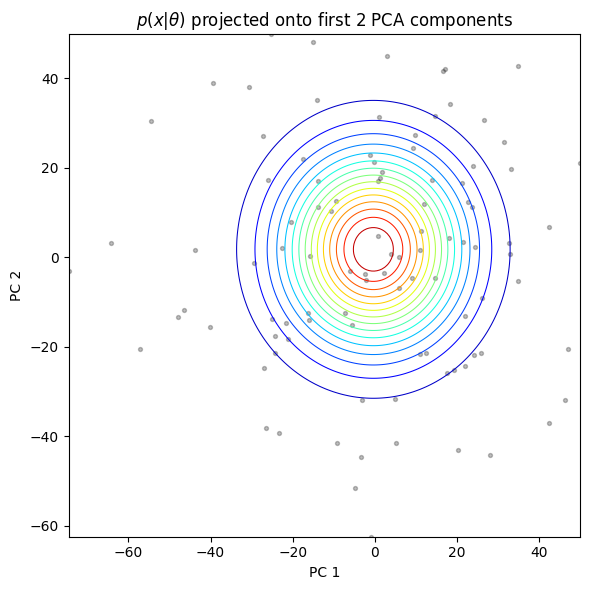

<Figure size 500x400 with 0 Axes>

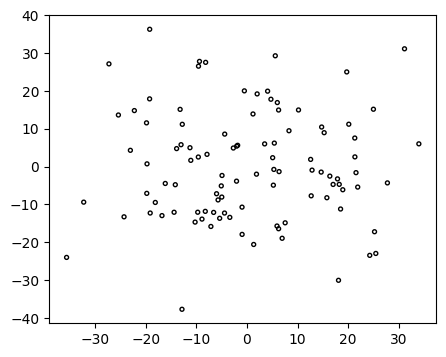

In [ ]:
DIR = 'results/FFD' 
IMG_FOLDER = "/home/amaranth2/Downloads/SimpleFace"
OUT_FOLDER = "/home/amaranth2/Downloads/out_folder"
problem = problem_FFD.FFD_Image_Problem(N=100, n=100)
problem.img_folder = IMG_FOLDER
problem.out_img_folder = OUT_FOLDER
problem.true_mean = 0.0
problem.true_var = 200.0
true_theta = problem.get_true_theta()
print(true_theta)
## The generated images are stored in a folder
## data_obs contains only the deformation parameters
problem.data_obs = problem.simulator(true_theta)
#uos.save_object(DIR, 'data_obs', problem.data_obs)

true_samples = problem.sample_from_true_posterior()
problem.visualize()
plt.figure(figsize=(5,4))
visualization.plot_samples(problem.data_obs)
#uos.save_object(DIR, 'true_samples', true_samples)

In [3]:
## Sequential Neural Likelihood
hyperparams = ABC_algorithms.Hyperparams()
hyperparams.save_dir = DIR
#hyperparams.device = 'cuda:1'
hyperparams.device = 'cpu'
hyperparams.num_sim = 4000  # Number of samples during the sampling/simulation loop
hyperparams.L = 2 # Number of posterior estimation rounds

print('\n SNL ABC')
snl_abc = SNLABC.SNL_ABC(problem, discrepancy=discrepancy.eculidean_dist, hyperparams=hyperparams)
snl_abc.run()

JSD_array = []
for l in range(len(snl_abc.nde_array)):
    print('l=', l)
    snl_abc.nde_net = snl_abc.nde_array[l]
    visualization.plot_likelihood(samples=true_samples, log_likelihood_function=snl_abc.log_likelihood, dimensions=(0,1))
    JSD = discrepancy.JSD(problem.log_likelihood, snl_abc.log_likelihood, true_samples, true_samples, N_grid=30)
    JSD_array.append(JSD)
    print('JSD snl = ', JSD)
uos.save_object(DIR, 'JSD_SNL', JSD_array)

NameError: name 'DIR' is not defined